## Check the metrics for various split of the entire dataset

- This section is created to check density and coverage for the entire dataset
- The dataset is split based on various ```split_size``` using ```stratify```
- For each split, the density and coverage is computed.

#### Example: 
- for ```split_size``` of 0.4, the ```X_model``` has 42,000 images and ```X_validation``` has 28,000 images
- the tree is trained on the ```X_model```
- the query dataset is ```X_validation```

In [18]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)
myranges = np.linspace(0.05, 0.4, 10) 
density_check = []
coverage_check = []
val_length = []
for i in myranges:
        X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=i, random_state=42, stratify=np.array(Y))
        real = np.array(X_model).reshape(len(X_model), -1)
        gen = np.array(X_validation).reshape(len(X_validation), -1)
        den = gem_build_density(real, real.shape[0], gen, 'indexflatl2')
        cov = gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
        density_check.append(den); coverage_check.append(cov); val_length.append(len(X_validation))
        #print(f"Split size: {i:.2f} | Validation size: {len(X_validation)} | Density: {den:.5f} | Coverage: {cov:.5f}")

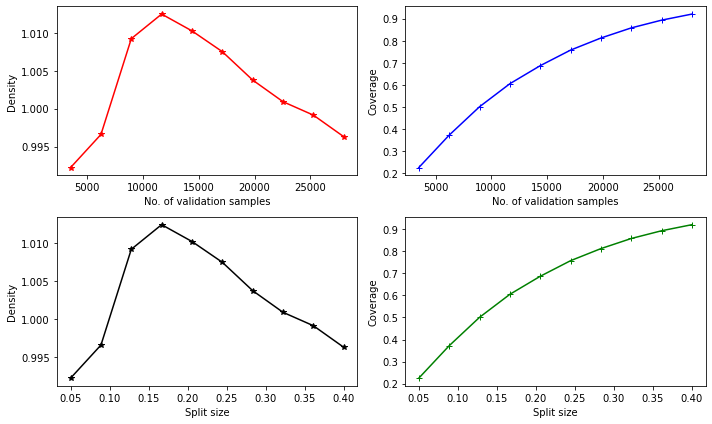

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax[0,0].plot(val_length, density_check, 'r-*')
ax[0,0].set_xlabel("No. of validation samples")
ax[0,0].set_ylabel("Density")


ax[0,1].plot(val_length, coverage_check, 'b-+')
ax[0,1].set_xlabel("No. of validation samples")
ax[0,1].set_ylabel("Coverage")

ax[1,0].plot(myranges, density_check, 'k-*')
ax[1,0].set_xlabel("Split size")
ax[1,0].set_ylabel("Density")


ax[1,1].plot(myranges, coverage_check, 'g-+')
ax[1,1].set_xlabel("Split size")
ax[1,1].set_ylabel("Coverage")
fig.tight_layout()
plt.savefig("Metrics_for_different_splitsizes.png")

-----------------------------------------------------------------------------------------------------------------

## Check the coverage using only 2 classes from the dataset

- Only 2 classes i.e, ```class 0``` and ```class 1``` is considered and coverage is computed for both the cases

- ```coverage00``` -> tree is trained on the entire class 0 and the query dataset is also class 0
- ```coverage005``` -> tree is trained on the entire class 0 and the query dataset is 50% of samples from class 0
- ```coverage01``` -> tree is trained on the entire class 0 and the query dataset is the samples from class 1

- ```classCom``` -> the dataset is formed by combininf class 0 and class 1
- ```coveragecom``` -> tree is trained on the entire classCom and the query dataset is the samples from class 0
- ```coveragecom5``` -> tree is trained on the entire classCom and the query dataset is 10% of samples from class 0

In [6]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)

In [21]:
X = torch.from_numpy(np.array(X)).cpu(); Y=torch.from_numpy(np.array(Y)).cpu();
#print(np.unique(Y, return_counts=True)); 
class0 = np.where(Y==0)[0]; class1 = np.where(Y==1)[0]; #print(len(class0), len(class1)); 
newX = X.reshape(X.shape[0], -1); #print(newX.shape)

classCom = torch.from_numpy(np.vstack([newX[class0], newX[class1]])).cpu()

#newX[class0].shape
coverage00 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0], 'indexflatl2')
coverage005 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0][:3452,...], 'indexflatl2')
coverage01 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class1], 'indexflatl2')
coveragecom = gem_build_coverage(classCom, classCom.shape[0], newX[class0], 'indexflatl2')
coveragecom5 = gem_build_coverage(classCom, classCom.shape[0], newX[class0][:600,...], 'indexflatl2')
print(f"Coverage: \n Class 0 & Class 0: {coverage00} \n Class 0 & Class 0 (50%): {coverage005} \n" +
      f" Class 0 & Class 1: {coverage01} \n \n Class 0 + Class 1 combined: {coveragecom} \n" +
     f" Class 0 + Class 1 combined(10%): {coveragecom5}")

Coverage: 
 Class 0 & Class 0: 1.0 
 Class 0 & Class 0 (50%): 0.9701579213142395 
 Class 0 & Class 1: 0.0020281036850064993 
 
 Class 0 + Class 1 combined: 0.4673207104206085 
 Class 0 + Class 1 combined(10%): 0.19668470323085785


----------------------------------------------------------------------------------------------------------------------------

# FGSM attack

#### Steps implemented

- #### Attack
    - 20 values of epsilons were considered
    - the model is attacked using the entire validation_set(2100) images -> generates adversarial samples
    - the model is attacked using batches of validation samples(100 images/ batch) -> batch adversarial samples

- #### Metrics
    - ```density``` & ```coverage``` 
    
        -> ```nmodel_vali_density``` --> model_dataset(22000 images stratified split) and validation set **[1 value]**
        
        -> ```bmodel_vali_density``` --> model_dataset(22000 images stratified split) and validation set in batches **[20 values, 1 for batch epsilon]**
        
        -> ```nmodel_vali_adv_density``` --> model_dataset(22000 images stratified split) and validation adversarial samples **[20 values, 1 for each epsilon]**
        
        -> ```bmodel_vali_adv_metrics``` --> model_dataset(22000 images stratified split) and validation batch adversarial samples **[400 values, for each epsilon 20 values]**
     

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
epsilon = np.linspace(0, 1, 20)

In [169]:
def all_metrics(path1, path2, path3, colnum, epsilon):
    """
    Funstion to compute and return the stats for the files
    
    Parameters
    ----------------------
    path1: str, the file path to the model_dataset & validation_set
    path2: str, the file path to the model_dataset & validation_set in batches
    path3: str, the file path to the model_dataset & validation adversarial samples in batches
    colnum: int, metrics column to choose in model_dataset & validation adv samples in batches 
            0 - density, 1 - coverage
    epsilon: np. array, the epsilon values
    
    Return
    ----------------------
    nmodel_vali - float, the metric between model_dataset & validation_set
    nmodel_vali_adv - np.array, the metric model_dataset & validation adv samples (len(epsilon), 1)
    q0, q25, q50, q75 - nparray, the 0, 25, 50, 75 quantile for model_dataset 
                & validation samples in batches (metric), size: len(epsilon)
    quantiles - np.array, the 0, 25, 50, 75 quantile for each batch of model_dataset & 
                validation adversarial samples in batches (metric), size: len(epsilon), 4
    quantities - np.array, the mean, median and mode for each batch of model_dataset & 
                validation adversarial samples in batches (metric), size: len(epsilon), 4 
    
    """
    
    # read the model_dataset & validation_set -> metric
    # read the model_dataset & validation adversarial sample -> metric (colnum: 1- density, colnum: 2 - coverage)
    df_nmodel_vali = pd.read_csv(path1, header=None, nrows=4)
    df_nmodel_vali_adv = pd.read_csv(path1, header=None, skiprows=4, sep=" ")
    
    # read the model_dataset & validation_set -> metric in batches
    # read the model_dataset & validation adversarial samples -> metric in batches
    df_bmodel_vali_metrics = pd.read_csv(path2, header=None, skiprows=4, sep=" ")
    df_bmodel_vali_adv_metrics = pd.read_csv(path3, header=None, skiprows=5, sep=" ")
    
    # nmodel_vali -> model_dataset & validation_set -> metric (1 value)
    # nmodel_vali_adv -> model_dataset & validation adversarial sample (length of epsilons)
    nmodel_vali = float((list(df_nmodel_vali.iloc[3].values))[0].split()[-1])
    nmodel_vali_adv = df_nmodel_vali_adv.iloc[:, -1].values
    
    # bmodel_vali -> model_dataset & validation_set -> metric (batch size X 1)
    # bmodel_vali_adv -> model_dataset & validation adversarial samples -> metric in batches (batch_size x len(epsilons))
    # colnum1: 0- density, colnum: 1 - coverage)
    bmodel_vali = df_bmodel_vali_metrics.iloc[:, colnum].values
    bmodel_vali_adv = df_bmodel_vali_adv_metrics.iloc[:, colnum].values
    
    
    quantiles = [] # store quantile info
    quantities= [] # store stats info
    for i in range(len(epsilon)):
        values = bmodel_vali_adv[i:400:20]
        val,cnt = np.unique(values, return_counts=True)
        idx = np.argmax(cnt)
        qvalues = np.quantile(values, [0, 0.25, 0.5, 0.75])
        quantiles.append(qvalues)
        quantities.append([np.mean(values), np.median(values), val[idx]])
    
    quantiles = np.array(quantiles)
    quantities = np.array(quantities)
    
    q = np.quantile(bmodel_vali, [0, 0.25, 0.5, 0.75])
    q0 = np.repeat(q[0], len(epsilon))
    q25 = np.repeat(q[1], len(epsilon))
    q50 = np.repeat(q[2], len(epsilon))
    q75 = np.repeat(q[3], len(epsilon))
    
    nmodel_vali = np.repeat(nmodel_vali, len(epsilon))
    
    return nmodel_vali, nmodel_vali_adv, q0, q25, q50, q75, quantiles, quantities    

#### Density

In [174]:
nmodel_vali_den, nmodel_vali_adv_den, den_q0, den_q25, den_q50, den_q75, den_quantiles, den_quantities = all_metrics('metrics_files/FGSM_attack_density.dat', 'metrics_files/FGSM_attack_batch_metrics.dat',
                                                                                                                 'metrics_files/FGSM_attack_batch_adv_metrics.dat', 0, epsilon)

#### Coverage

In [175]:
nmodel_vali_cov, nmodel_vali_adv_cov, cov_q0, cov_q25, cov_q50, cov_q75, cov_quantiles, cov_quantities = all_metrics('metrics_files/FGSM_attack_coverage.dat', 'metrics_files/FGSM_attack_batch_metrics.dat',
                                                                                                                 'metrics_files/FGSM_attack_batch_adv_metrics.dat', 1, epsilon)

In [190]:
cov_q75

array([0.02665, 0.02665, 0.02665, 0.02665, 0.02665, 0.02665, 0.02665,
       0.02665, 0.02665, 0.02665, 0.02665, 0.02665, 0.02665, 0.02665,
       0.02665, 0.02665, 0.02665, 0.02665, 0.02665, 0.02665])

## Plot

- ```model_vali``` --> model_dataset(22000 images stratified split) and validation set **[1 value]**
- ```model_vali_adv``` --> model_dataset(22000 images stratified split) and validation adversarial samples **[20 values, 1 for each epsilon]**

In the coverage plot, the uncertainity band was constructed by
 - for each epsilon, 
     - take ```model_vali +  nmodel_vali_adv_density``` -> forms upper bound
     - take ```model_vali -  nmodel_vali_adv_density``` -> forms lower bound

- P.S: this will be rectifed by the next meeting


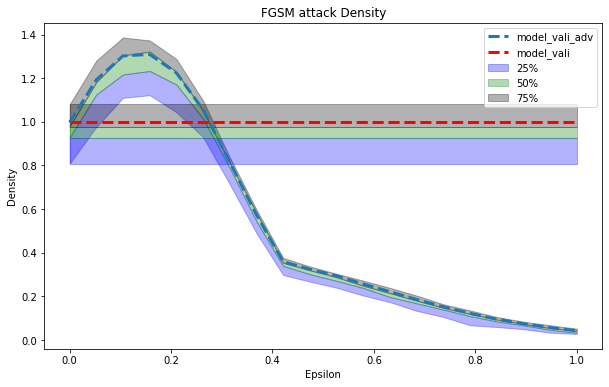

In [180]:
fig,ax = plt.subplots(figsize=(10, 6))
ax.plot(epsilon, nmodel_vali_adv_den, label='model_vali_adv', lw=3, ls='--')
ax.fill_between(epsilon, den_quantiles[:,0], den_quantiles[:,1], color='b', alpha=0.3, label='25%')
ax.fill_between(epsilon, den_quantiles[:,1], den_quantiles[:,2], color='g', alpha=0.3, label='50%')
ax.fill_between(epsilon, den_quantiles[:,2], den_quantiles[:,3], color='k', alpha=0.3, label='75%')
ax.plot(epsilon, nmodel_vali_den, ls='--', lw=3, c='r', label='model_vali')
ax.fill_between(epsilon, den_q0, den_q25, color='b', alpha=0.3)
ax.fill_between(epsilon, den_q25, den_q50, color='g', alpha=0.3)
ax.fill_between(epsilon, den_q50, den_q75, color='k', alpha=0.3)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Density")
ax.set_title("FGSM attack Density")
ax.legend()


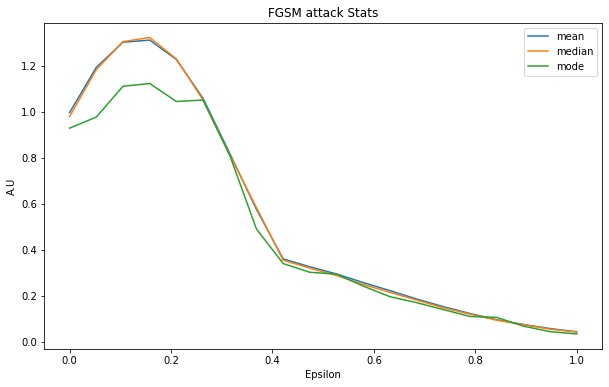

In [182]:
fig,ax = plt.subplots(figsize=(10, 6))
ax.plot(epsilon, quantities[:,0], label='mean')
ax.plot(epsilon, quantities[:,1], label='median')
ax.plot(epsilon, quantities[:,2], label='mode')
ax.set_xlabel("Epsilon")
ax.set_ylabel("A.U")
ax.set_title("FGSM attack Stats")
ax.legend()

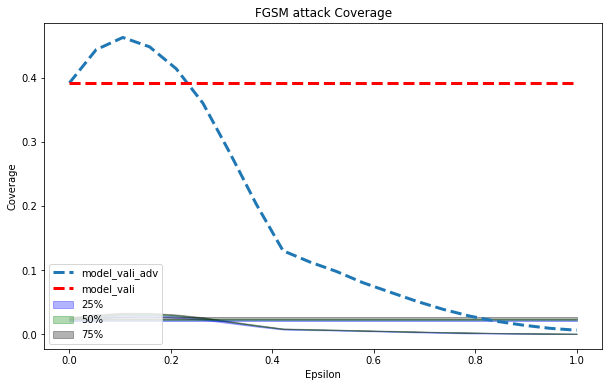

In [186]:
fig,ax = plt.subplots(figsize=(10, 6))
ax.plot(epsilon, nmodel_vali_adv_cov, label='model_vali_adv', lw=3, ls='--')
ax.fill_between(epsilon, cov_quantiles[:,0], cov_quantiles[:,1], color='b', alpha=0.3, label='25%')
ax.fill_between(epsilon, cov_quantiles[:,1], cov_quantiles[:,2], color='g', alpha=0.3, label='50%')
ax.fill_between(epsilon, cov_quantiles[:,2], cov_quantiles[:,3], color='k', alpha=0.3, label='75%')
ax.plot(epsilon, nmodel_vali_cov, ls='--', lw=3, c='r', label='model_vali')
ax.fill_between(epsilon, cov_q0, cov_q25, color='b', alpha=0.3)
ax.fill_between(epsilon, cov_q25, cov_q50, color='g', alpha=0.3)
ax.fill_between(epsilon, cov_q50, cov_q75, color='k', alpha=0.3)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Coverage")
ax.set_title("FGSM attack Coverage")
ax.legend()
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

# Boundary Attack

### Attack the model using validation_dataset

- the Boundary Attack cannot be implemented if the starting images are not adversaries
- to create these adversarial samples, ```init_attack``` needs to be specified
- any of the attacks inherited from ```Minimization Attack``` can be used for this purpose
- all the initial samples should be strictly adversarial samples

##### Two different attacks were experimented
- ```SaltandPepper```, ```LinearSearchBlendedUniformNoiseAttack```
- modify the hyperparameters within these attacks to generate the adversarial samples
- the generated samples are given as the starting points for the ```BoundaryAttack```
- time complexity increases with changing these hyperparameters

--------------------------------------------------------------------------------------------------------------------------

The steps implemedted for the FGSM attack remains the same, however, 2 points were changed

- the ```epsilon``` value is nullified i.e., **None** was specified.
- the model_dataset has 67000 images for the computation of metrics

The uncertainity band is implemented the same way as stated for FGSM attack


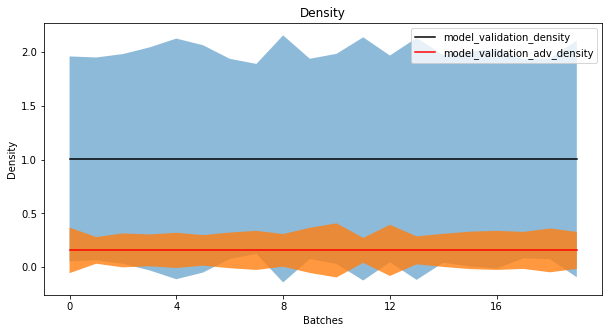

In [199]:
# plot density
plt.figure(figsize=(10,5))
plt.plot(range(len(derror)), dx, c='k', label='model_validation_density')
plt.fill_between(range(len(derror)), dx-derror, dx+derror, alpha=0.5)

plt.plot(range(len(derror_adv)), dadv_x, c='r', label='model_validation_adv_density')
plt.fill_between(range(len(derror_adv)), dadv_x-derror_adv, dadv_x+derror_adv, alpha=0.8)

plt.xticks(range(0,20,4))
plt.xlabel('Batches')
plt.ylabel('Density')
plt.title('Density')
plt.legend()
plt.savefig("BoundaryAttack_density.png")

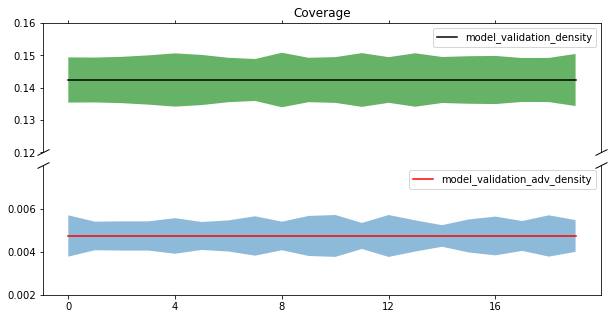

In [200]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax1.plot(range(len(cerror)), cx, c='k', label='model_validation_density')
ax1.fill_between(range(len(cerror)), cx-cerror, cx+cerror, alpha=0.6, facecolor='g')
ax1.legend()
ax2.plot(range(len(cerror_adv)), cadv_x, c='r', label='model_validation_adv_density')
ax2.fill_between(range(len(cerror_adv)), cadv_x-cerror_adv, cadv_x+cerror_adv, alpha=0.5)
ax2.legend()
ax1.set_ylabel("Coverage")
ax1.set_title("Coverage")

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(.12, 0.16)  # outliers only
ax2.set_ylim(0.002, .008)  # most of the data
ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False) # don't put tick labels at the top
ax2.set_xticks(range(0,21,4))
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig("BoundaryAttack_coverage.png")